# CPSC 330 - Applied Machine Learning 

## Homework 5: Evaluation metrics
### Associated lectures: [Lectures 9, 10](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Monday, Feb 27, 2023 at 11:59pm**

## Imports

In [1]:
import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import tests_hw5
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

## Instructions 
<hr>
rubric={points:3}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Exercise 1: Precision, recall, and f1 score by hand <a name="1"></a>
<hr>

Consider the problem of predicting whether a patient has cancer or not. It is important to catch this disease early to reduce mortality rate; late diagnosis will result in metastasis to other organs, which adversely impacts patient's prognosis. Below are confusion matrices of two machine learning models: Model A and Model B. 

- Model A

|         | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 48 | 32 |
| **Actual no disease**       | 20 | 100 |


- Model B

|        | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 43 | 22 |
| **Actual no disease**       | 35 | 100 |

### 1.1 Positive vs. negative class 
rubric={points:2}

**Your tasks:**

Precision, recall, and f1 score depend upon which class is considered "positive", that is the thing you wish to find. In the example above, which class is likely to be the "positive" class? Why? 

The "positive" class would likely be actually having the disease because in this model we want to predict which patients have the disease. 

<br><br>

### 1.2 Accuracy
rubric={points:2}

**Your tasks:**

Calculate accuracies for Model A and Model B. 

We'll store all metrics associated with Model A and Model B in the `results_dict` below. 

In [2]:
results_dict = {"A": {}, "B": {}}

In [3]:
model_A = pd.DataFrame(
    [[48,32],
     [20,100]],
    columns= ["Predicted disease", "Predicted no disease"], 
    index=["Actual disease", "Actual no disease"])

model_B = pd.DataFrame(
    [[43,22],
     [35,100]],
    columns= ["Predicted disease", "Predicted no disease"], 
    index=["Actual disease", "Actual no disease"])

results_dict["A"]["accuracy"] = np.diag(model_A).sum() / model_A.sum().sum()
results_dict["B"]["accuracy"] = np.diag(model_B).sum() / model_B.sum().sum()


In [4]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.74,0.715


### 1.3 Which model would you pick? 
rubric={points:1}

**Your tasks:**

Which model would you pick simply based on the accuracy metric? 

I would pick Model A because it has a higher accuracy than Model B. Model A has a accuracy of 0.74 whilst model B only has accuracy of 0.715. However, it should be noted that this is the only information we currently have. 

<br><br>

### 1.4 Precision, recall, f1-score
rubric={points:6}

**Your tasks:**

1. Calculate precision, recall, f1-score for Model A and Model B manually, without using `scikit-learn` tools. 


In [5]:
def f1(precision, recall):
    return (2 * precision * recall) / (precision + recall)

In [6]:
results_dict["A"]["recall"] = model_A.iloc[0,0] / model_A.iloc[0,:].sum()
results_dict["B"]["recall"] = model_B.iloc[0,0] / model_B.iloc[0,:].sum()
results_dict["A"]["precision"] = model_A.iloc[0,0] / model_A.iloc[:,0].sum()
results_dict["B"]["precision"] = model_B.iloc[0,0] / model_B.iloc[:,0].sum()
results_dict["A"]["f1"] = f1(results_dict["A"]["precision"], results_dict["A"]["recall"])
results_dict["B"]["f1"] = f1(results_dict["B"]["precision"], results_dict["B"]["recall"])

Show the dataframe with all results. 

In [7]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.740000,0.715000
recall,0.600000,0.661538
precision,0.705882,0.551282
f1,0.648649,0.601399


<br><br>

### 1.5 Discussion
rubric={points:4}

**Your tasks:**
1. Given the type of problem (early cancer diagnosis), which metric is more informative in this problem? Why? 
2. Which model would you pick based on this information? 

In this question we are trying to early diagnose patients with the disease. Therefore we want to maximize recall because it's better to catch more real positives and avoid false negatives so I would actually choose Model B because it has a higher recall score at 0.66 compared to Model A which has 0.60. Model B has a slightly lower f1 score than model A but since we want to maximize recall in this specific example, I would still choose model B.

<br><br>

### (Optional) 1.6 
rubric={points:1}

**Your tasks:**

Provide 2 to 3 example classification datasets (with links) where accuracy metric would be misleading. Discuss which evaluation metric would be more appropriate for each dataset. You may consider datasets we have used in this course so far. You could also look up datasets on Kaggle. 

https://www.kaggle.com/datasets/denisadutca/customer-behaviour this is a dataset I found about customer dataset and whether they chose to buy a product or not. This is a case where f1 score and precision is more relevant because the company should focus of the customers most likely to make a purchase rather than wasting resources.

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud This was the dataset we learned in class about credit card fraud, because of the severe consequences of one instance of fraud, Recall and f1 score should be maximized. 


<br><br><br><br>

### Exercise 2: Classification evaluation metrics using `sklearn` <a name="2"></a>
<hr>

In general, when a dataset is imbalanced, accuracy does not provide the whole story. In class, we looked at credit card fraud dataset which is a classic example of an imbalanced dataset. 

Another example is customer churn datasets. [Customer churn](https://en.wikipedia.org/wiki/Customer_attrition) refers to the notion of customers leaving a subscription service like Netflix. In this exercise, we will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. To start, please download the [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). Once you have the data, you should be able to run the following code:

The starter code below reads the data CSV as a pandas dataframe and splits it into 70% train and 30% test. 

Note that `churn` column in the dataset is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.

> Note that for this kind of problem a more appropriate technique is something called survival analysis and we'll be talking about it later in the course. For now, we'll just treat it as a binary classification problem. 

In [8]:
df = pd.read_csv("bigml_59c28831336c6604c800002a.csv", encoding="utf-8")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,False
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,False
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,False
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,False
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,...,112,20.95,285.3,104,12.84,12.5,8,3.38,2,False
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,...,92,14.45,127.9,68,5.76,9.4,4,2.54,3,False
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,...,121,11.88,171.6,96,7.72,11.6,7,3.13,2,False
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,...,147,20.92,242.0,106,10.89,10.4,5,2.81,1,True


<br><br>

### 2.1 Distribution of target values
rubric={points:4}

**Your tasks:**

Examine the distribution of target values in the train split. Do you see class imbalance? If yes, do we need to deal with it? Why or why not? 

In [9]:
#code from lecture 
train_df["churn"].value_counts(normalize=True)


False    0.850407
True     0.149593
Name: churn, dtype: float64

There is a class imbalance in this data set because 15% of the examples in the training data belong to the True class whilst the vast majority of 85% belong to the "False". We are interested the in the True data because we want to find the customers that churned and therefore give them other offers to keep their subscription so prediction True here is the focus. 

<br><br>

### (Optional) 2.2 EDA 
rubric={points:1}

**Your tasks:**

Come up with **two** exploratory questions you would like to answer and explore those. Briefly discuss your results in 1-3 sentences.

You are welcome to use `pandas_profiling` (see Lecture 10) but you don't have to.

<br><br>

### 2.3 Column transformer 
rubric={points:14}

The code below creates `X_train`, `y_train`, `X_test`, `y_test` for you. 
In preparation for building a classifier, set up a `ColumnTransformer` that performs whatever feature transformations you deem sensible. This can include dropping features if you think they are not helpful. Remember that by default `ColumnTransformer` will drop any columns that aren't accounted for when it's created.

For each group of features (e.g. numeric, categorical or else) explain why you are applying the particular transformation. For example, "I am doing transformation X to the following categorical features: `a`, `b`, `c` because of reason Y," etc.

Finally, fit `ColumnTransformer` on your training set; and use the `ColumnTransformer` to transform your train data.

In [10]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

In [11]:
train_df.head() 

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,False
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,False
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,False
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,False
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,False


In [12]:
train_df["area code"].unique()
train_df["state"].unique()
train_df["international plan"].unique()
train_df["voice mail plan"].unique()
train_df["state"].value_counts()
len(train_df["phone number"].unique())

2333

* drop the column `phone number` 
* OHE `area code` `state` `international plan` `voice mail plan`. Therefore international plan, and voice mail plan are binary features, area code and state are categorical features and the rest are numeric features 

In [13]:
cat_features = ["area code", "state"]
bin_features = ["international plan", "voice mail plan"]
drop = ["phone number"]
num_features = list(
    set(train_df.columns)
    - set(["churn"])
    - set(bin_features)
    - set(cat_features)
    - set(drop)
)

preprocessor = make_column_transformer(
    (StandardScaler(), num_features),
    (OneHotEncoder(drop="if_binary"), bin_features),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), cat_features),
    ("drop", drop),
)

In [14]:
preprocessor.fit(X_train);
preprocessor.named_transformers_

{'standardscaler': StandardScaler(),
 'onehotencoder-1': OneHotEncoder(drop='if_binary'),
 'onehotencoder-2': OneHotEncoder(handle_unknown='ignore', sparse=False),
 'drop': 'drop'}

In [15]:
transformed_columns = (
    num_features
    + bin_features
    + list(preprocessor.named_transformers_["onehotencoder-2"].get_feature_names_out(
            cat_features))
)

X_train_transformed = pd.DataFrame(
    preprocessor.transform(X_train), index=X_train.index, columns=transformed_columns)
X_train_transformed.head()


,total intl charge,total eve calls,total eve minutes,total day charge,total night calls,number vmail messages,total day calls,total intl minutes,total night charge,total eve charge,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
1402,-1.644994,-1.156734,0.069871,0.618927,0.052115,-0.587624,-0.721211,-1.645501,1.089926,0.069926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1855,0.222249,-1.207278,-1.167277,-1.293517,-0.720990,-0.587624,1.655252,0.227019,-2.164029,-1.166291,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
633,1.916105,0.157417,-2.210130,-0.609654,-0.463288,1.900976,0.169963,1.919489,0.369252,-2.211244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1483,-0.097850,0.258506,-0.754894,0.998611,0.000574,-0.587624,-0.473663,-0.097071,1.596582,-0.755774,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2638,0.408973,-0.246937,1.195994,-0.994731,0.206736,-0.587624,0.764078,0.407069,0.792921,1.196515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.4 area code feature
rubric={points:4}

The original dataset had a feature called `area code`.

1. The area codes are numbers. Does it make sense to encode them as one-hot-endoded (OHE) or not? Please justify your response.
2. What were the possible values of `area code`? 
3. If area code is encoded with OHE, how many new features are created to replace it?

the area code are categories so we need to sue OHE, the actual number of the area code doesn't have any value. 

In [16]:
X_train["area code"].unique()
# these are the possible values of the area code

array([415, 510, 408])

In [17]:
area_code_new = X_train_transformed.columns[X_train_transformed.columns.str.startswith("area code")]
area_code_new
# 408 is [1,0,0]
# 415 is [0,1,0]
# 510 is [0,0,1]


Index(['area code_408', 'area code_415', 'area code_510'], dtype='object')

In [18]:
X_train_transformed.loc[X_train["area code"] == 408][area_code_new].iloc[0].values
X_train_transformed.loc[X_train["area code"] == 415][area_code_new].iloc[0].values
X_train_transformed.loc[X_train["area code"] == 510][area_code_new].iloc[0].values


array([0., 0., 1.])

pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
### 2.5 Logistic regression
rubric={points:12} 

**Your tasks:**

1. Report the cross-validation results of a `LogisticRegression` model, with default Hparams, on the following metrics: `"accuracy", "precision", "recall", "f1"`
2. Are you satisfied with the results? Explain why or why not. Discuss in a few sentences. 

In [19]:
pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       0.019781
score_time     0.002827
test_score     0.855978
train_score    0.866481
dtype: float64

In [20]:
scores = ["accuracy", "precision", "recall", "f1"]
for scores in scores:
    print(scores,cross_val_score(pipe, X_train, y_train, scoring=scores).mean(),)

accuracy 0.8559777963625003
precision 0.548663382594417
recall 0.20931677018633543
f1 0.30273912862476837


I'm not really satisfied with these scores because the recall and the f1 scores are still very low. a low recall means that we rarely predict true and this is probably the results of the original class imbalance of the dataset where only 15 percent are "true" examples. 

<br><br>

### 2.6 Logistic regression with `class_weight`
rubric={points:6}

**Your tasks:**

1. Set the `class_weight` parameter of your logistic regression model to `'balanced'` and report the same metrics as in the previous part. 
2. Do you prefer this model to the one in the previous part? Discuss your results in a few sentences while comparing the metrics of this model and the previous model.

In [21]:
pipe_balanced = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, class_weight="balanced"))
pd.DataFrame(cross_validate(pipe_balanced, X_train, y_train, return_train_score=True)).mean()
scores = ["accuracy", "precision", "recall", "f1"]
for scores in scores:
    print(scores,cross_val_score(pipe_balanced, X_train, y_train, scoring=scores).mean(),)

accuracy 0.7608072713236713
precision 0.35115409339151793
recall 0.6992132505175984
f1 0.46702681999685014


After using class weight, our accuracy dropped but the recall scored a lot higher. Overall f1 score is higher as well. Thus,i would prefer this momdel because it has a much higher f1 score and recall score than the previous model because for this example it is the "true" examples we are interested in so maximizing recall and f1 is the most important.

### 2.7 Hyperparameter optimization
rubric={points:10}

1. Jointly optimize `C` and `class_weight` with `GridSearchCV` and `scoring="f1"`.
  - For `class_weight`, consider 3 values: 
    - `None` (no weight)
    - "weight of class 0 = 1"  and  "weight of class 1 = 3"
    - '`balanced`'
  - For `C`, choose some reasonable values
2. What values of `C` and `class_weight` are chosen and what is the best cross-validation f1 score?

In [22]:
#code taken from lecture 10 
pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

param_grid = {
    "logisticregression__C": [0.0625, 0.125 , 0.25  , 0.5   , 1.    , 2.    , 4.    , 8.    ], #c values we've seen in class
    "logisticregression__class_weight": [None, "weight of class 0=1", "weight of class 1=3", "balanced"],
}
search = GridSearchCV(
    pipe,
    param_grid,
    verbose=1,
    n_jobs=-1,
    return_train_score=True,
    scoring="f1",
)

search.fit(X_train, y_train);


Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [23]:
grid_result = pd.DataFrame(search.cv_results_)[
    [
        "mean_test_score",
        "mean_train_score",
        "param_logisticregression__C",
        "param_logisticregression__class_weight",
        "rank_test_score",
    ]
]
grid_result = grid_result.sort_values(by="mean_test_score", ascending=False)
grid_result


,mean_test_score,mean_train_score,param_logisticregression__C,param_logisticregression__class_weight,rank_test_score
3,0.481077,0.496341,0.0625,balanced,1
7,0.477458,0.503381,0.125,balanced,2
11,0.475169,0.507852,0.25,balanced,3
15,0.469676,0.513824,0.5,balanced,4
19,0.467027,0.512418,1.0,balanced,5
23,0.465481,0.512885,2.0,balanced,6
31,0.461991,0.513988,8.0,balanced,7
27,0.461813,0.514124,4.0,balanced,8
30,0.312894,0.371034,8.0,weight of class 1=3,9
29,0.312894,0.371034,8.0,weight of class 0=1,9


Thus, the best C value for the values chosen is 0.0625, and class_weight of balanced and the best cross validation f1 score is 0.481077


<br><br>

### 2.8 Test results
rubric={points:10}

**Your tasks**
1. Evaluate the best model on the test set. In particular show each of the following on the test set:  
    - Plot Confusion matrix
    - Plot Precision-recall curve 
    - Calculate average precision score
    - Plot ROC curve
    - Report AUC score
3. Comment on the AUC score and give an intuitive explanation of what this value of AUC means for this problem.

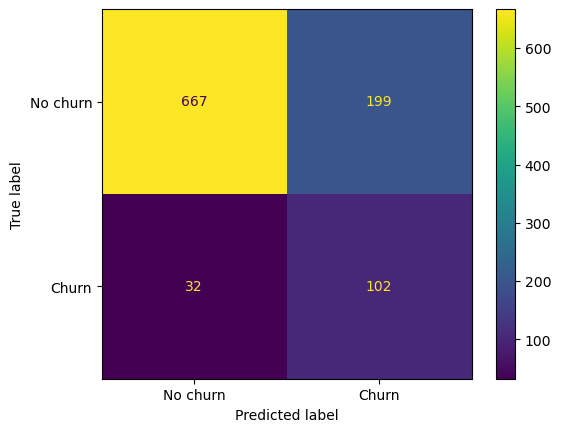

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

#confusion matrix plot
cm = ConfusionMatrixDisplay.from_estimator(
    search, X_test, y_test, display_labels=["No churn", "Churn"])

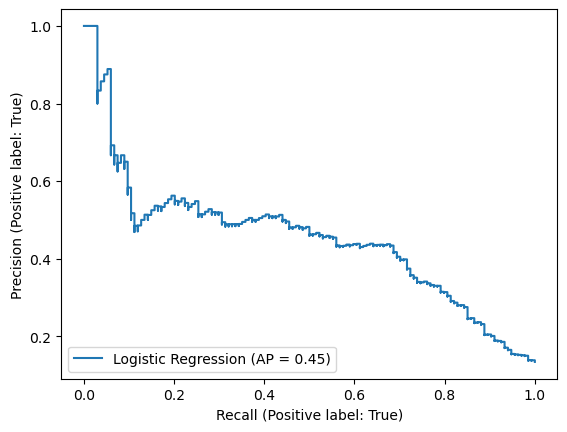

In [25]:
#precision recall curve
#Average precision score is 0.45
PrecisionRecallDisplay.from_estimator(search, X_test, y_test, name="Logistic Regression")

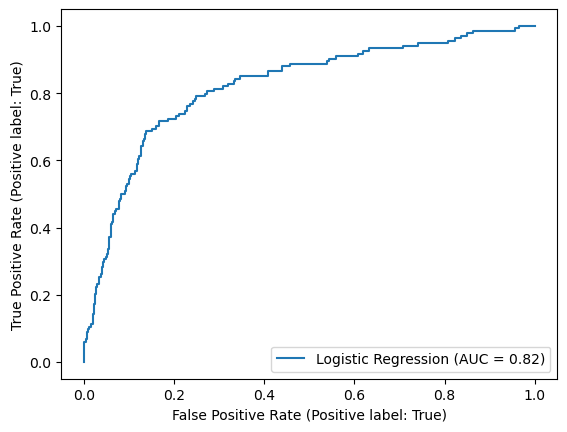

In [26]:
#plot ROC curve
RocCurveDisplay.from_estimator(search, X_test, y_test, name="Logistic Regression")

In [27]:
# print auc score
print(roc_auc_score(y_test, search.predict_proba(X_test)[:, 1]))


0.8210937230705594


from the last graph, AUC score is 0.82. this means that 82% of the positive cases will score larger than the negative cases. It's a pretty reasonable AUC score on average. 

<br><br><br><br>

### Exercise 3: Regression metrics <a name="3"></a>
<hr> 


For this exercise, we'll use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from `sklearn datasets`. The code below loads the dataset.  

In [28]:
from sklearn.datasets import fetch_california_housing

housing_df = fetch_california_housing(as_frame=True).frame

### 3.1: Data spitting and exploration 
rubric={points:4}

**Your tasks:**

1. Split the data into train (75%) and test (25%) splits. 
2. Explore the train split. Do you need to apply any transformations on the data? If yes, create a preprocessor with the appropriate transformations. 
3. Separate `X` and `y` to train and test splits. 

In [29]:
train_df, test_df = train_test_split(housing_df, test_size=0.25, random_state=123)
train_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
19995,1.0349,6.0,4.165217,0.982609,734.0,3.191304,36.19,-119.35,0.678
17889,4.7625,13.0,5.265207,1.002433,1087.0,2.644769,37.41,-121.95,1.375
1977,3.5192,9.0,8.747475,1.845118,796.0,2.680135,38.61,-120.44,0.980
6861,2.8672,30.0,4.635616,1.090411,1130.0,3.095890,34.06,-118.13,1.985
11247,4.1276,13.0,4.429936,0.963376,1749.0,2.785032,33.81,-118.00,1.538


In [30]:
train_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000
mean,3.875935,28.550000,5.421818,1.095860,1437.431137,3.073942,35.626601,-119.568380,2.074085
std,1.900729,12.546577,2.519280,0.492851,1131.575270,10.971330,2.135537,2.001982,1.156051
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.750000,32.540000,-124.350000,0.149990
25%,2.562500,18.000000,4.433750,1.005778,791.000000,2.429227,33.930000,-121.800000,1.203000
50%,3.534300,29.000000,5.228714,1.048412,1173.000000,2.815468,34.250000,-118.490000,1.805000
75%,4.750375,37.000000,6.047297,1.099043,1742.000000,3.278071,37.710000,-118.010000,2.655000
max,15.000100,52.000000,141.909091,34.066667,28566.000000,1243.333333,41.950000,-114.310000,5.000010


next we need to apply standard scaler to preprocess the data because all the features in this dataset are numeric and on a different scale. 

In [31]:
# it appears that all the features in the dataset here are 
# numeric so we have the scale for the transformations
preprocessor = StandardScaler()

X_train, y_train = train_df.drop(columns=["MedHouseVal"]), train_df["MedHouseVal"]
X_test, y_test = test_df.drop(columns=["MedHouseVal"]), test_df["MedHouseVal"]


### 3.2 Baseline: Linear Regression 
rubric={points:2}

**Your tasks:**
1. Carry out cross-validation using `sklearn.linear_model.LinearRegression` with default scoring. 
2. What metric is used for scoring by default? 

In [32]:
# we get the R squared score by default
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
pd.DataFrame(cross_validate(lr, X_train, y_train, return_train_score=True)).mean()


fit_time       0.010207
score_time     0.000739
test_score     0.486547
train_score    0.606753
dtype: float64

The default scoring metric for `sklearn.linear_model.LinearRegression` is the $R^2$ score 

<br><br>

### 3.3 Random Forest Regressor
rubric={points:7}

In this exercise, we are going to use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model which we haven't looked into yet. At this point you should feel comfortable using models with our usual ML workflow even if you don't know the details. We'll talk about `RandomForestRegressor` later in the course.  

The code below defines a custom scorer called `mape_scorer` and creates dictionaries for two model (`models`) and five evaluation metrics (`score_types_reg`). 

**Your tasks:**

1. Using the `models` and the evaluation metrics `score_types_reg` in the code below, carry out cross-validation with each model, by passing the evaluation metrics to `scoring` argument of `cross_validate`. Use a pipeline with the model as an estimator if you are applying any transformations. 
2. Show results as a dataframe. 
3. Interpret the results. How do the models compare to the baseline? Which model seems to be performing well with different metrics? 


In [33]:
models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "neg_mean_absolute_percentage_error": "neg_mean_absolute_percentage_error",
}

In [34]:
def random_forest_metric(models, preprocessor, scoring="f1"):
    results = {}
    for (name, model) in models.items():
        pipeline = make_pipeline(preprocessor, model)
        scores = cross_validate(pipeline, X_train, y_train, return_train_score=True, scoring=scoring)
        df = pd.DataFrame(scores)
        results[name] = df.mean()
    return pd.DataFrame(results)

In [35]:
random_forest_metric(models, preprocessor, scoring=score_types_reg)


,Ridge,Random Forest
fit_time,0.002540,4.939904
score_time,0.001089,0.054774
test_neg_mean_squared_error,-0.678763,-0.268519
train_neg_mean_squared_error,-0.525484,-0.037664
test_neg_root_mean_squared_error,-0.808948,-0.518061
train_neg_root_mean_squared_error,-0.724900,-0.194068
test_neg_mean_absolute_error,-0.536109,-0.337910
train_neg_mean_absolute_error,-0.531897,-0.126158
test_r2,0.486522,0.798744
train_r2,0.606753,0.971812


note: for this question 3.3, it says that there is a custom scorer called `mape_scorer` but I don't technically see it so I'm just doing the tasks assuming the given `score_types_reg` `test_neg_mean_absolute_percentage_error` is the `mape_scorer`

Ridge has about the same test $R^2$ score to the baseline linear regressor. Random forest has a much higher test $R^2$ score neg root mean squared error and neg mean absolute percentage error score. The Random Forest model will only has an error of around 19% with the test set. However, it should be noted that the Random Forest model has a fit time much longer than ridge and baseline linear regression. 


<br><br>

### 3.4 Hyperparameter optimization 
rubric={points:1}

1. Carry out hyperparameter optimization using `RandomizedSearchCV` and `Ridge` with the following `param_dist`. The `alpha` hyperparameter of `Ridge` controls the fundamental tradeoff. Choose `neg_mean_absolute_percentage_error` as the HParam optimization metric.

2. What was the best `alpha` hyper-parameter found?

In [36]:
from scipy.stats import loguniform

param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}


In [37]:
pipe = make_pipeline(StandardScaler(), Ridge())

ridge_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_absolute_percentage_error',
    random_state=123,
)
ridge_search.fit(X_train, y_train)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('ridge', Ridge())]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'ridge__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16b58d420>},
                   random_state=123,
                   scoring='neg_mean_absolute_percentage_error', verbose=1)

In [38]:
ridge_search.best_params_


{'ridge__alpha': 26.789982776216593}

The best alpha hyperparameter found was 26.78

### 3.5 Test results
rubric={points:4}

**Your tasks:**

Test the best model (from 3.4) on the test set based on the `neg_mean_absolute_percentage_error` score.

In [39]:
print(ridge_search.best_params_) # best optimized parameters
print(ridge_search.best_score_) # best model score from grid search
print(ridge_search.score(X_train, y_train)) # trains score
print(ridge_search.score(X_test, y_test)) # test score


{'ridge__alpha': 26.789982776216593}
-0.318206973890714
-0.31761517157235397
-0.3162239459029977


the `neg_mean_absolute_percentage_error` score on the full test set is -31.62

<br><br>

### 3.6 Model interpretation  
rubric={points:4}

Ridge is a linear model and it learns coefficients associated with each feature during `fit()`. 

**Your tasks:**

1. Explore coefficients learned by the `Ridge` model above as a pandas dataframe with two columns: 
   - features 
   - coefficients
2. Increasing which feature values would result in higher housing price? 

In [40]:
ridge_coefficients = pd.DataFrame(
    data={"features": X_train.columns,
        "coefficients": ridge_search.best_estimator_.named_steps["ridge"].coef_,
         }
)
ridge_coefficients.sort_values(["coefficients"], ascending=[False])

,features,coefficients
0,MedInc,0.834197
3,AveBedrms,0.306563
1,HouseAge,0.120021
4,Population,-0.002402
5,AveOccup,-0.042213
2,AveRooms,-0.270699
7,Longitude,-0.842722
6,Latitude,-0.873340


Increasing the features that have a positive coefficient will result in higher housing prices. Here, the features are MedInc (median income), AveBedrms (average bedrooms), HouseAge (house age). 

<br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 